# Sistema de recomendação
A partir do perfil dos clientes que já realizaram compras na feira, serão criados grupos de perfis de clientes com base nos produtos comprados. Esses grupos poderão ser então utilizados para realização de recomendações de produtos a serem sugeridas ao longo do processo de compra em pedidos futuros, classificando-se o cliente em algum dos grupos de perfil e sugerindo-se produtos deste grupo ao cliente.<p>
Inicialmente faremos o agrupamento dos clientes utilizando K-Means, dada sua boa performance para grande quantidade de dados quando comparado a outras opções como, por exemplo, Hierarchical Clustering. DBSCAN foi descartado pois sua detecção de outliers traria complicações indesejadas.

In [202]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report,confusion_matrix,ConfusionMatrixDisplay
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

Dentre os data sets que temos disponíveis, o mais apropriado para esta situação é o que contém informações de pedidos em formato wide.

In [3]:
df = pd.read_csv('arquivos/pedidos_wide_final.csv')
df.head()

,id_pedido,data_pedido,hora_pedido,id_cliente,bairro_pedido,cidade_pedido,cep_pedido,tipo_pagamento,agente,i_agua de coco,...,vl_tot_pimentao [ 500g ],i_abobrinha,qt_abobrinha,vl_tot_abobrinha,i_quiabo [ kg ],qt_quiabo [ kg ],vl_tot_quiabo [ kg ],i_pepino amarelo [ unidade ],qt_pepino amarelo [ unidade ],vl_tot_pepino amarelo [ unidade ]
0,54,2020-07-03,11:30:53,39,aldeota,fortaleza,60150060,Pagar ao retirar na loja,android,True,...,0.0,False,0.0,0.0,False,0.0,0.0,False,0.0,0.0
1,56,2020-07-03,11:32:27,38,sao gerardo,fortaleza,60320105,Cartão de Crédito,windows,False,...,0.0,False,0.0,0.0,False,0.0,0.0,False,0.0,0.0
2,59,2020-07-03,11:38:01,35,manoel satiro,fortaleza,60713480,Cartão de Crédito,windows,False,...,0.0,False,0.0,0.0,False,0.0,0.0,False,0.0,0.0
3,60,2020-07-03,11:38:27,33,rodolfo teofilo,fortaleza,60431075,Débito/Transferência,android,True,...,0.0,False,0.0,0.0,False,0.0,0.0,False,0.0,0.0
4,64,2020-07-03,11:49:13,40,rodolfo teofilo,fortaleza,60430660,Cartão de Crédito,android,False,...,0.0,False,0.0,0.0,False,0.0,0.0,False,0.0,0.0


## Criação dos grupos de clientes com K-Means
Optaremos por utilizar a quantidade de cada produto comprada pelos clientes, dado que tal informação nos traz conhecimento mais aprofundado sobre os clientes. Há mais informação em saber que um cliente comprou dez garrafas de cajuína do que simplesmente saber que ele comprou cajuína, por exemplo, já que um cliente que comprou sete garrafas está mais próximo de um outro que comprou dez do que um terceiro que comprou somente uma.

In [17]:
# Selecionando as colunas de interesse: as que contém quantidade de itens por produtos
cols_int = [col for col in df.columns if 'qt_' in col and col != 'qt_final_itens']

X = df[cols_interesse]
scaler = StandardScaler()
scaled_X = scaler.fit_transform(X)

A escolha da quantidade de grupos se dará por meio do método do cotovelo. Testaremos diversos valores para K (quantidade de clusters) e verificaremos a clareza na separação dos grupos. A forma de quantificar esta clareza é através da medição da soma do quadrado das distâncias (SSD) de cada ponto para o centro de seu cluster. Enquanto o aumento de K estiver resultando em decréscimo significativo de SSD, continuaremos aumentando K. Quando este decréscimo reduzir, não mais vale a pena aumentar K. Testaremos valores de K entre 2 e 200.

In [27]:
ssd = list()

for k in range(2,200):
    modelo_kmeans = KMeans(n_clusters=k)
    modelo_kmeans.fit(scaled_X)
    
    ssd.append(modelo_kmeans.inertia_) # Aqui está SSD.

Vamos visualizar graficamente o progresso do valor de SSD conforme K foi aumentado e procurar pelo cotovelo que demonstra que inexpressiva de SSD para descobrirmos o melhor valor para K.

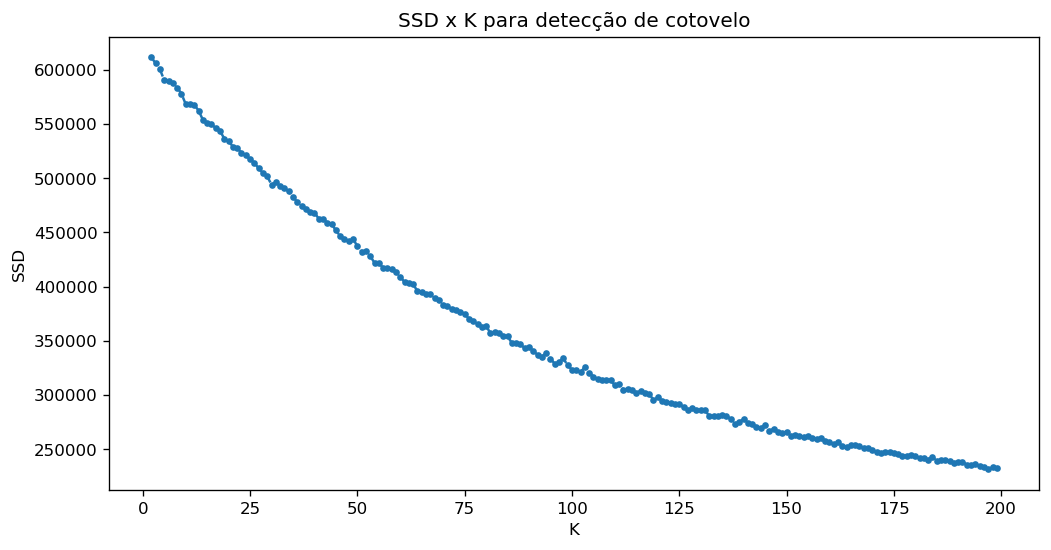

In [29]:
plt.figure(dpi=120,figsize=(10,5))
plt.xlabel('K')
plt.ylabel('SSD')
plt.title('SSD x K para detecção de cotovelo')
plt.plot(range(2,200),ssd,'.--');

Como a quantidade de produtos é bastante grande, não queremos uma quantidade de clusters (K) muito pequena para evitar perfis de clientes muito genéricos. Por esta razão, ignoraremos alguns pontos onde K ainda é pequeno e SSD não reduziu significativamente com K + 1. Perceba também um cotovelo bastante interessante na área onde K está entre 25 e 50.

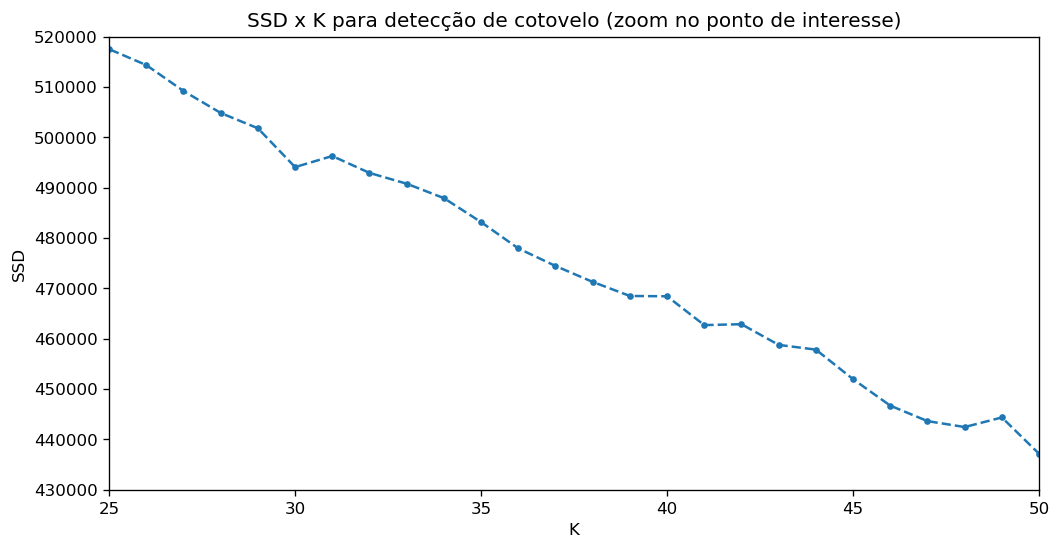

In [69]:
plt.figure(dpi=120,figsize=(10,5))
plt.xlabel('K')
plt.ylabel('SSD')
plt.title('SSD x K para detecção de cotovelo (zoom no ponto de interesse)')
plt.xlim(25,50)
plt.ylim(430000,520000)
plt.plot(range(2,200),ssd,'.--');

Podemos ver que SSD com K = 31 é maior que SSD com K = 30, portanto 30 é um bom valor para K. Vamos classificar os pedidos dentro desses 30 grupos.<p>
**Importante:** este modelo deve ser retreinado sempre que houver acréscimo ou remoção de produtos no inventário de produtos. Também deve ser retreinado com alguma frequência para levar em consideração compras mais recentes.

In [70]:
modelo_kmeans = KMeans(n_clusters=30)
labels = modelo_kmeans.fit_predict(scaled_X)
df['grupo'] = labels

Quantos pedidos temos por grupo?

In [71]:
df['grupo'].value_counts()

10    1902
3      608
0      396
7      290
19      77
12      41
8       40
6       33
9       25
4       21
26      14
15      14
29       8
24       7
17       6
5        6
11       6
16       5
14       5
21       5
23       3
27       3
28       3
25       2
13       2
22       1
1        1
20       1
2        1
18       1
Name: grupo, dtype: int64

Dada a quantidade de partâmetros que temos em X, o mapa de calor a seguir torna-se bastante difícil de ler. Mesmo assim, ele é visualizável caso aberto em outra aba pois foi gerado com resolução bastante alta. Não é possível aprender muita coisa dele, mas podemos perceber que alguns grupos pois correlção mais direta com algum produto específico. Alguns padrões de compra também são verificáveis.

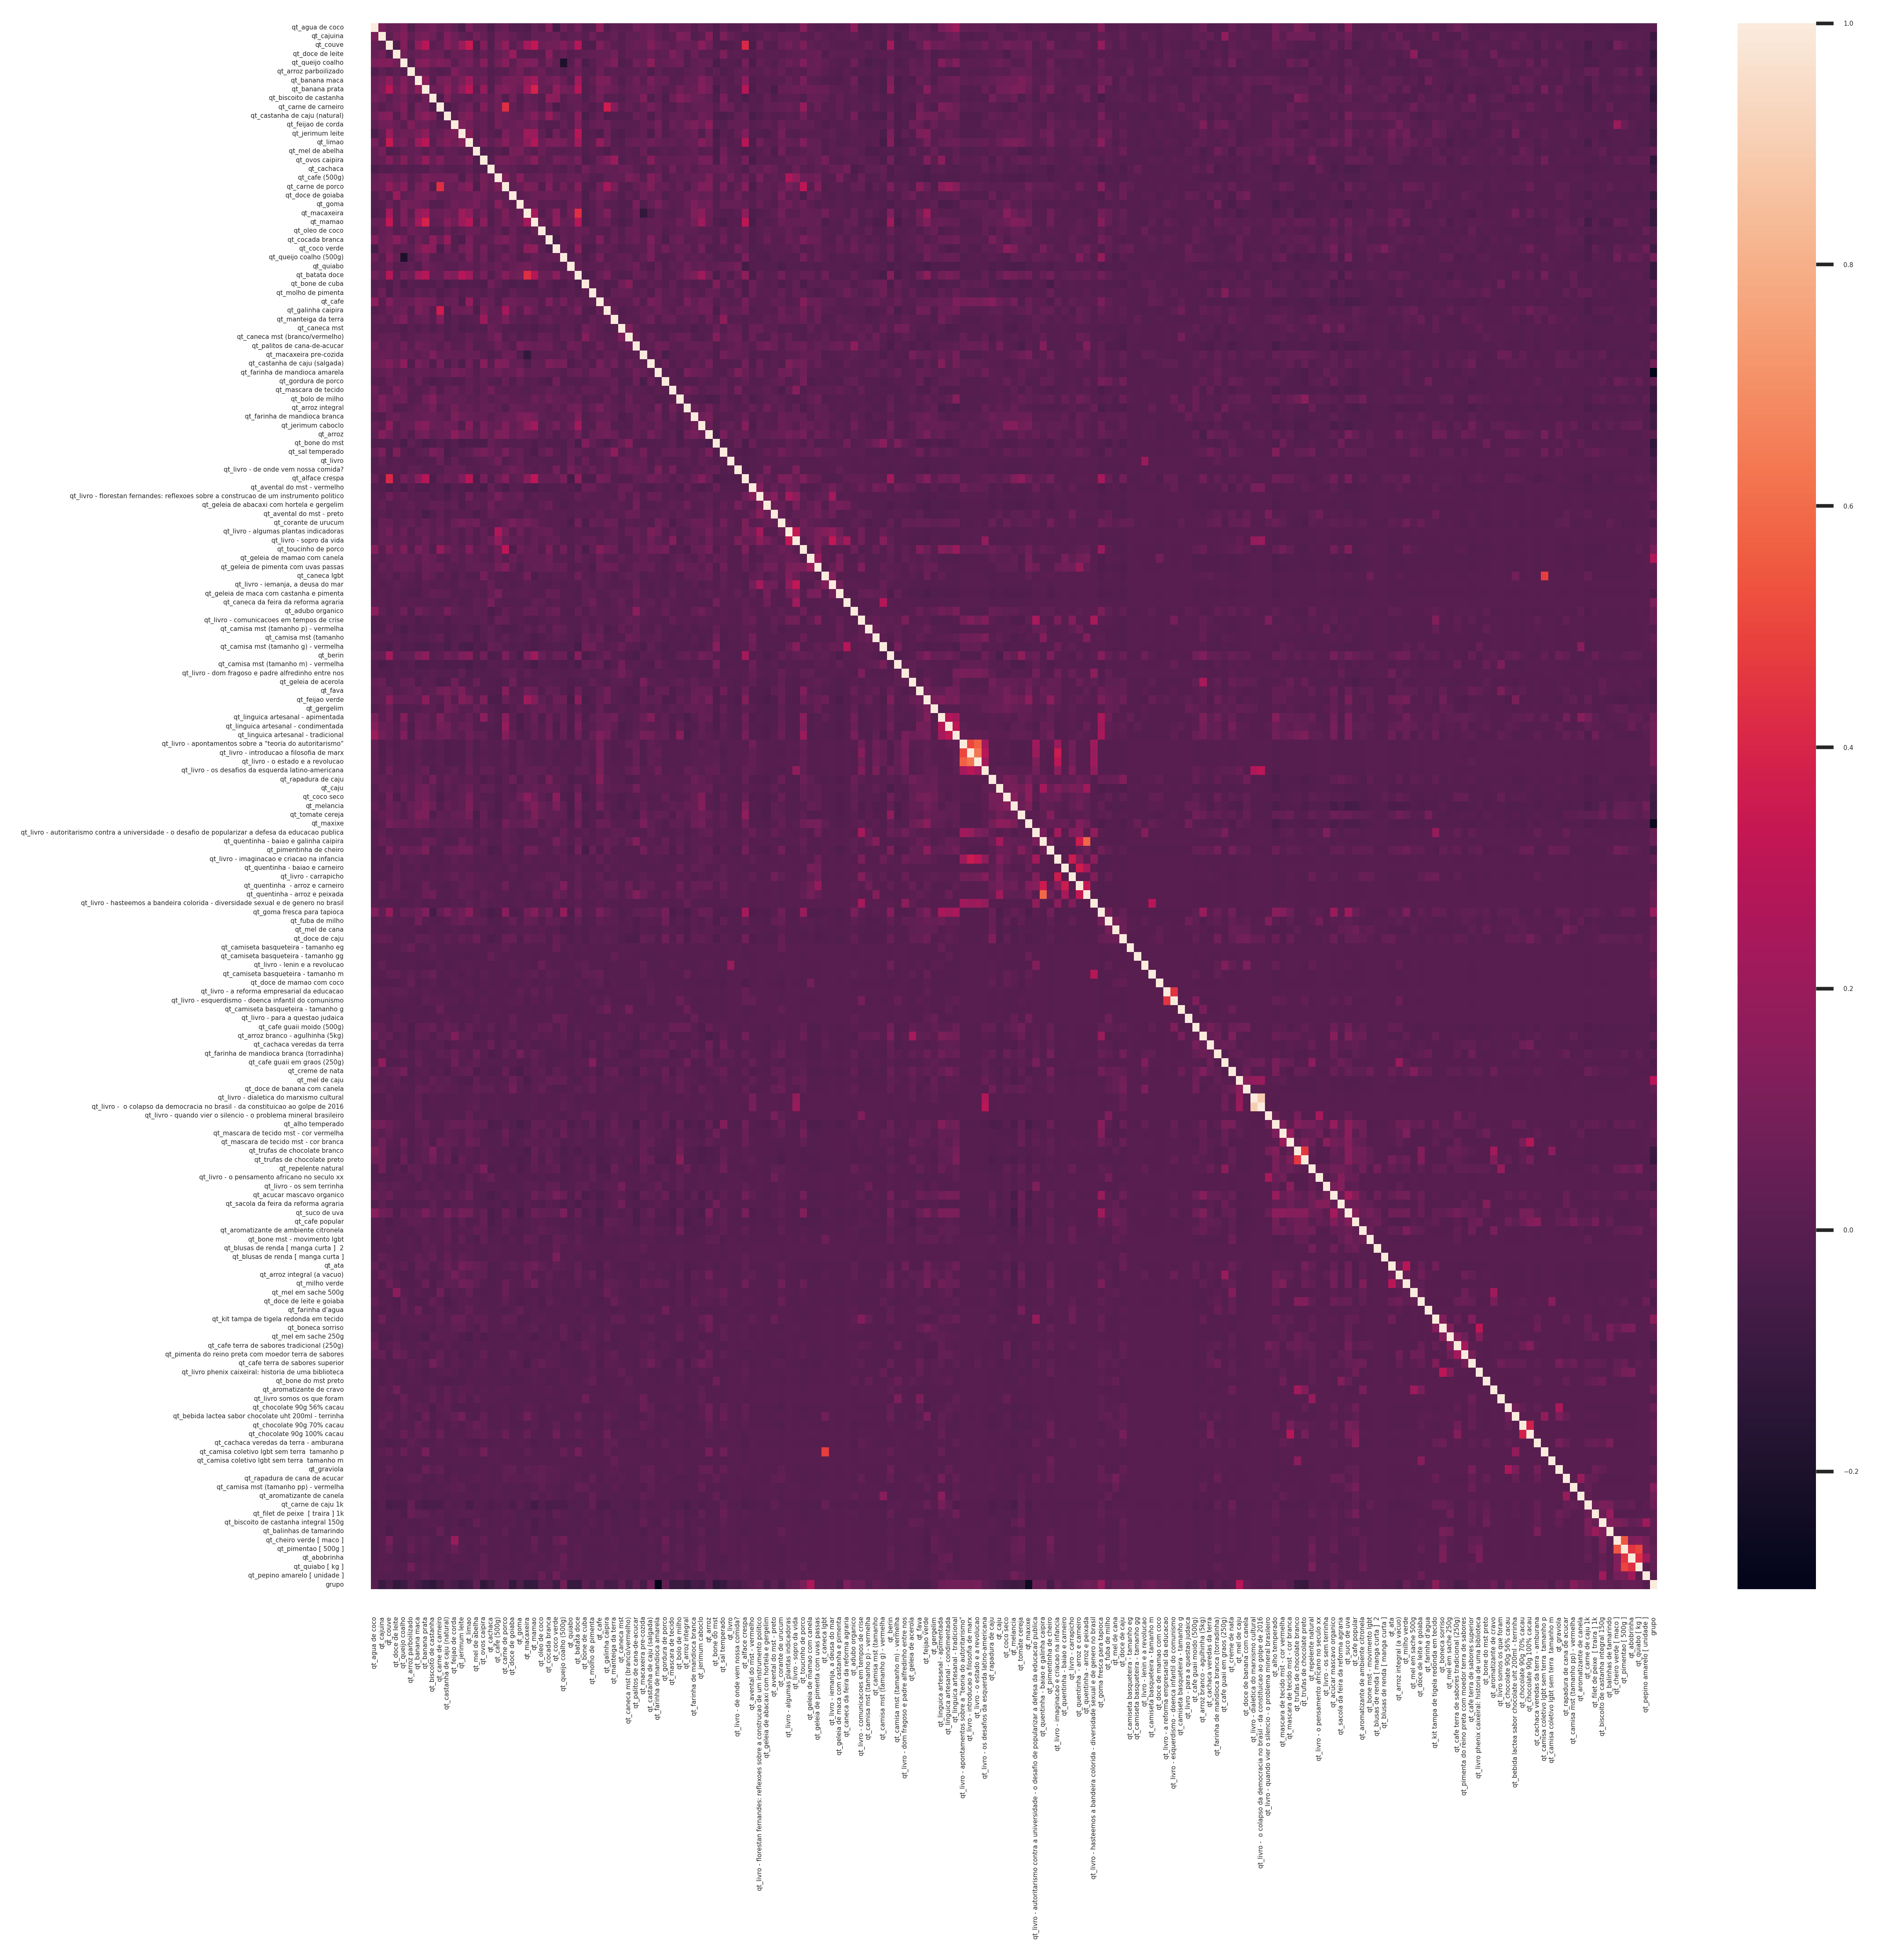

In [81]:
plt.figure(dpi=500,figsize=(10,10))
sns.set(font_scale=0.2)
sns.heatmap(X.corr());

É necessário descobrir quais os produtos mais populares para cada grupo.

In [158]:
prods_grupos = dict()

for grupo in df['grupo'].unique():
    prods_grupo = list() # Lista de produtos, do mais popular para o menos popular, onde quantidade de produtos > 0
    lista_prods = df[df['grupo'] == grupo][cols_interesse].sum().sort_values(ascending=False)
    
    for i in range(0,len(lista_prods)):
        if lista_prods.values[i] > 0:
            prods_grupo.append(lista_prods.index[i])
        else:
            break
            
    prods_grupos[grupo] = [prod[3:] for prod in prods_grupo]

Abaixo podemos ver um dicionário com uma lista de produtos para cada grupo, estando eles dos mais populares para os menos populares.

In [159]:
prods_grupos

{10: ['ovos caipira',
  'cajuina',
  'biscoito de castanha',
  'couve',
  'banana prata',
  'limao',
  'castanha de caju (natural)',
  'mel de abelha',
  'queijo coalho (500g)',
  'agua de coco',
  'coco verde',
  'mamao',
  'queijo coalho',
  'batata doce',
  'doce de leite',
  'castanha de caju (salgada)',
  'alface crespa',
  'feijao de corda',
  'macaxeira pre-cozida',
  'cocada branca',
  'goma',
  'feijao verde',
  'carne de carneiro',
  'arroz',
  'galinha caipira',
  'carne de porco',
  'goma fresca para tapioca',
  'jerimum leite',
  'macaxeira',
  'adubo organico',
  'cafe',
  'jerimum caboclo',
  'doce de goiaba',
  'manteiga da terra',
  'coco seco',
  'banana maca',
  'linguica artesanal - condimentada',
  'arroz integral',
  'rapadura de caju',
  'sal temperado',
  'corante de urucum',
  'linguica artesanal - tradicional',
  'mascara de tecido',
  'bone de cuba',
  'gergelim',
  'cachaca',
  'molho de pimenta',
  'berin',
  'doce de caju',
  'bone do mst',
  'farinha de m

Vamos validar se o produtos no dicionário estão corretos verificando os produtos mais populares do grupo 10 diretamente no DataFrame.

In [157]:
df[df['grupo'] == 10][cols_interesse].sum().sort_values(ascending=False)

qt_ovos caipira                                                      828.0
qt_cajuina                                                           799.0
qt_biscoito de castanha                                              774.0
qt_couve                                                             650.0
qt_banana prata                                                      649.0
                                                                     ...  
qt_boneca sorriso                                                      0.0
qt_livro - a reforma empresarial da educacao                           0.0
qt_livro - quando vier o silencio - o problema mineral brasileiro      0.0
qt_camiseta basqueteira - tamanho m                                    0.0
qt_pepino amarelo [ unidade ]                                          0.0
Length: 176, dtype: float64

Podemos ver que o dicionário está correto.<p>
**Importante:** ao implantar em produção, esse dicionário deve ser exportado juntamente com o modelo classificador que modelaremos a seguir. O sistema da loja deverá chamar o modelo classificador para descobrir o grupo do cliente e, em seguida, consultar este dicionário para saber quais produtos recomendar, não esquecendo de ignorar produtos que já estejam no carrinho de compras. Produtos que não estiverem disponíveis em estoque também deveriam ser ignorados.

## Classificando um carrinho de compras ativo em um dos grupos
Criados os grupos, podemos treinar alguns modelos de <u>classiicação</u> e compará-los para descobrir qual conseguiria fazer melhor predição de recomendações. Testaremos alguns modelos e compararemos suas performances para decidir qual é o mais apropriado.<p>
Utilizaremos Grid Search para otimização de hiper parâmetros e Cross Validation para melhor utilização da massa para treinamento e teste. Os dados serão separados da seguinte forma:
- 80% para treinamento;
- 10% para teste;
- 10% para avaliação final do modelo.

In [167]:
# Determinando X e y
X = df[cols_interesse]
y = df['grupo']

# Separando a massa conforme descrito acima
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
X_holdout, X_test, y_holdout, y_test = train_test_split(X_test, y_test, test_size=0.5)

Vamos verificar o tamanho dos grupos para garantir que a separação se deu de forma correta.

In [168]:
print(f"Tamanho de X: {len(X)}")
print(f"Tamanho de y: {len(y)}")
print(f"Tamanho de X_train: {len(X_train)}")
print(f"Tamanho de y_train: {len(y_train)}")
print(f"Tamanho de X_test: {len(X_test)}")
print(f"Tamanho de y_test: {len(y_test)}")
print(f"Tamanho de X_holdout: {len(X_holdout)}")
print(f"Tamanho de y_holdout: {len(y_holdout)}")

Tamanho de X: 3527
Tamanho de y: 3527
Tamanho de X_train: 2821
Tamanho de y_train: 2821
Tamanho de X_test: 353
Tamanho de y_test: 353
Tamanho de X_holdout: 353
Tamanho de y_holdout: 353


Normalizando os dados.

In [169]:
scaler = StandardScaler()
scaler.fit(X_train) # Fit somente com dados de treinamento para evitar data leakage
scaled_X_train = scaler.transform(X_train)
scaled_X_test = scaler.transform(X_test)
scaled_X_holdout = scaler.transform(X_holdout)

Vamos criar uma função genérica que irá nos mostrar métricas de performance do modelos que testaremos.

In [186]:
def reportar(model):
    y_pred = model.predict(scaled_X_test)
    print(f"Melhores parâmetros: {model.best_params_}")
    print(classification_report(y_test,y_pred))
    cm = confusion_matrix(y_test,y_pred)
    ConfusionMatrixDisplay(cm).plot()
    plt.show()

### Regressão logística
Trata-se do modelo mais simples de classificação. Consiste de uma adaptação da regressão linear, utilizando-se de uma função sigmóide para decidir se um grupo de parâmetros pertence a uma classe (1) ou não (0). Sua performance computacional normalmente deixa a desejar quando comparada a modelos mais modernos.<p>
Testaremos a aplicação das técnicas de redução de complexidade ridge (l1) e lasso (l2), assim como elasticnet, que é uma mistura das duas, tentando atingir a melhor performance do modelo. O emprego dessas técnicas diminuem a chance de overfitting ocorrer Serão mostradas algumas mensagens de warning porque o parâmetro <code>l1_ratio</code>, que determina a quantidade de ridge no elasticnet, só faz sentido quando elasticnet está sendo usado. Também testaremos alguns valores para o hiper parâmetro <code>C</code>, que determina a força da regularização. Um número máximo de iteração também será informado para diminuir os warnings devido à impossibilidade de convergência do modelo.

/home/luciano/miniconda3/envs/Pos/lib/python3.9/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/home/luciano/miniconda3/envs/Pos/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1476: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/home/luciano/miniconda3/envs/Pos/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1476: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/home/luciano/miniconda3/envs/Pos/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1476: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/home/luciano/miniconda3/envs/Pos/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1476: UserWarning: l1_ratio parameter is only used when pe

/home/luciano/miniconda3/envs/Pos/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1476: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/home/luciano/miniconda3/envs/Pos/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1476: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/home/luciano/miniconda3/envs/Pos/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1476: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/home/luciano/miniconda3/envs/Pos/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1476: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/home/luciano/miniconda3/envs/Pos/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1476: UserWarning: l1_ratio parameter is only used when pena

Melhores parâmetros: {'C': 1.0, 'l1_ratio': 0.0, 'max_iter': 1000, 'penalty': 'l2'}
              precision    recall  f1-score   support

           0       0.96      0.88      0.92        56
           3       0.89      0.93      0.91        54
           4       1.00      1.00      1.00         2
           6       0.50      1.00      0.67         2
           7       0.94      1.00      0.97        29
           8       1.00      1.00      1.00         2
           9       0.00      0.00      0.00         1
          10       0.97      0.98      0.97       193
          12       1.00      0.67      0.80         3
          15       0.00      0.00      0.00         1
          19       1.00      1.00      1.00         6
          24       0.00      0.00      0.00         1
          26       0.00      0.00      0.00         1
          29       1.00      1.00      1.00         2

    accuracy                           0.94       353
   macro avg       0.66      0.67      0.66       

/home/luciano/miniconda3/envs/Pos/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/luciano/miniconda3/envs/Pos/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/luciano/miniconda3/envs/Pos/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result)

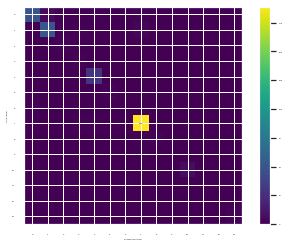

In [190]:
modelo_log = LogisticRegression()

penalty = ['l1','l2','elasticnet'] # 3 técnicnas de redução de complexidade
l1_ratio = np.linspace(0,1,3) # 3 valores de l1_ratio
C = np.logspace(0,10,5) # 5 valores de C
max_iter = [1000]
param_grid = {'penalty':penalty,'l1_ratio':l1_ratio,'C':C,'max_iter':max_iter}

modelo_grid_log = GridSearchCV(modelo_log,param_grid=param_grid)
modelo_grid_log.fit(scaled_X_train,y_train)
reportar(modelo_grid_log)

### K-nearest neighbors
A teoria por trás de K-nearest neighbors é bastante simples. Basicamente decide a classe de um ponto verificando-se a classe dos seus k vizinhos mais próximos. O principal parâmetro a ser ajustado é justamente o k, que testaremos com Grid Search. Como temos algumas classes com menos de 5 ocorrências, alguns warnings serão retornados.

/home/luciano/miniconda3/envs/Pos/lib/python3.9/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


Melhores parâmetros: {'n_neighbors': 5}
              precision    recall  f1-score   support

           0       0.85      0.52      0.64        56
           3       0.82      0.26      0.39        54
           4       1.00      0.50      0.67         2
           6       0.00      0.00      0.00         2
           7       0.85      0.38      0.52        29
           8       1.00      1.00      1.00         2
           9       0.00      0.00      0.00         1
          10       0.69      0.97      0.81       193
          12       1.00      1.00      1.00         3
          14       0.00      0.00      0.00         0
          15       1.00      1.00      1.00         1
          19       1.00      0.83      0.91         6
          24       0.00      0.00      0.00         1
          26       1.00      1.00      1.00         1
          29       1.00      1.00      1.00         2

    accuracy                           0.73       353
   macro avg       0.68      0.56      0

/home/luciano/miniconda3/envs/Pos/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/luciano/miniconda3/envs/Pos/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/luciano/miniconda3/envs/Pos/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/

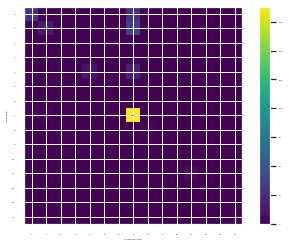

In [201]:
modelo_knn = KNeighborsClassifier()

n_neighbors = list(range(5,31,5)) # de 5 a 30 vizinhos, com step de 5.
param_grid = {'n_neighbors':n_neighbors}

modelo_grid_knn = GridSearchCV(modelo_knn,param_grid=param_grid)
modelo_grid_knn.fit(scaled_X_train,y_train)
reportar(modelo_grid_knn)

### Support vector machines
Basicamente, SVM separa pontos em um plano cartesiano multidimensional com hiper planos. Esta separação define as classes. Os dados são projetados em uma quantidade maior de dimensões o que permite que separações que não são possíveis na quantidade "normal" de dimensões sejam realizadas. Um classificador de tamanho de margem pode ser determinado para definir uma tolerância de existência de pontos de uma classe em uma partição que não é a da sua classe. Há diversos kernels se aproximam do problema de forma distinta. Testaremos algumas das possíveis combinações com Grid Search.

/home/luciano/miniconda3/envs/Pos/lib/python3.9/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


Melhores parâmetros: {'C': 0.1, 'degree': 2, 'gamma': 'scale', 'kernel': 'linear'}
              precision    recall  f1-score   support

           0       0.98      0.91      0.94        56
           3       0.86      0.91      0.88        54
           4       1.00      1.00      1.00         2
           6       1.00      0.50      0.67         2
           7       0.94      1.00      0.97        29
           8       1.00      1.00      1.00         2
           9       1.00      1.00      1.00         1
          10       0.97      0.98      0.98       193
          12       1.00      1.00      1.00         3
          15       1.00      1.00      1.00         1
          19       1.00      0.83      0.91         6
          24       1.00      1.00      1.00         1
          26       1.00      1.00      1.00         1
          29       1.00      1.00      1.00         2

    accuracy                           0.95       353
   macro avg       0.98      0.94      0.95       3

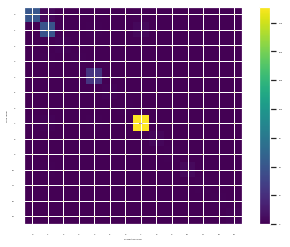

In [208]:
modelo_svm = SVC()

C = [0.001,0.01,0.1,0.5,1]
kernel = ['linear','rbf','poly']
gamma = ['scale','auto']
degree = [2,3,4]
param_grid = {'C':C,'kernel':kernel,'gamma':gamma,'degree':degree}

modelo_grid_svm = GridSearchCV(modelo_svm,param_grid=param_grid)
modelo_grid_svm.fit(scaled_X_train,y_train)
reportar(modelo_grid_svm)

<font color='red'>**Testar random forests e algum boosted tree**</font>